In [2]:
import pandas as pd
import os
import pickle
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load images
with open("/content/drive/MyDrive/Plankton/image_dataframe.pkl", "rb") as f:
    df = pickle.load(f)

print(df.head())
print(df.columns)


  Image_Class                                       Image_Matrix
0         mix  [[204, 204, 204, 203, 203, 203, 203, 200, 202,...
1         mix  [[200, 201, 203, 201, 199, 200, 202, 201, 199,...
2         mix  [[221, 222, 223, 224, 223, 222, 221, 222, 222,...
3         mix  [[192, 191, 188, 183, 182, 189, 185, 180, 185,...
4         mix  [[212, 212, 212, 212, 213, 213, 213, 211, 212,...
Index(['Image_Class', 'Image_Matrix'], dtype='object')


In [4]:
counts = df["Image_Class"].value_counts()
print(counts)
print(len(df))

Image_Class
mix                      500
Ciliate_mix              500
Dactyliosolen            500
Cerataulina              500
mix_elongated            500
Cylindrotheca            500
Mesodinium_sp            500
DactFragCerataul         500
Guinardia_striata        500
Ditylum                  500
Asterionellopsis         500
Chaetoceros              500
Leptocylindrus           500
G_delicatula_parasite    500
bad                      500
Corethron                500
Dictyocha                500
Guinardia_delicatula     500
flagellate_sp3           500
Dinobryon                500
detritus                 500
dino30                   500
Name: count, dtype: int64
11000


In [5]:
df.drop(df[df["Image_Class"] == "Ciliate_mix"].index, inplace=True)
df.drop(df[df["Image_Class"] == "mix_elongated"].index, inplace=True)
df.drop(df[df["Image_Class"] == "mix"].index, inplace=True)
df.drop(df[df["Image_Class"] == "detritus"].index, inplace=True)
df = df[df["Image_Class"] != "bad"]


In [6]:
# Drop rows where Image_Class == "bad"


# Check result
print(df["Image_Class"].value_counts())
print(len(df))


Image_Class
Dactyliosolen            500
Cerataulina              500
Cylindrotheca            500
Mesodinium_sp            500
DactFragCerataul         500
Guinardia_striata        500
Ditylum                  500
Asterionellopsis         500
Chaetoceros              500
Leptocylindrus           500
G_delicatula_parasite    500
Corethron                500
Dictyocha                500
Guinardia_delicatula     500
flagellate_sp3           500
Dinobryon                500
dino30                   500
Name: count, dtype: int64
8500


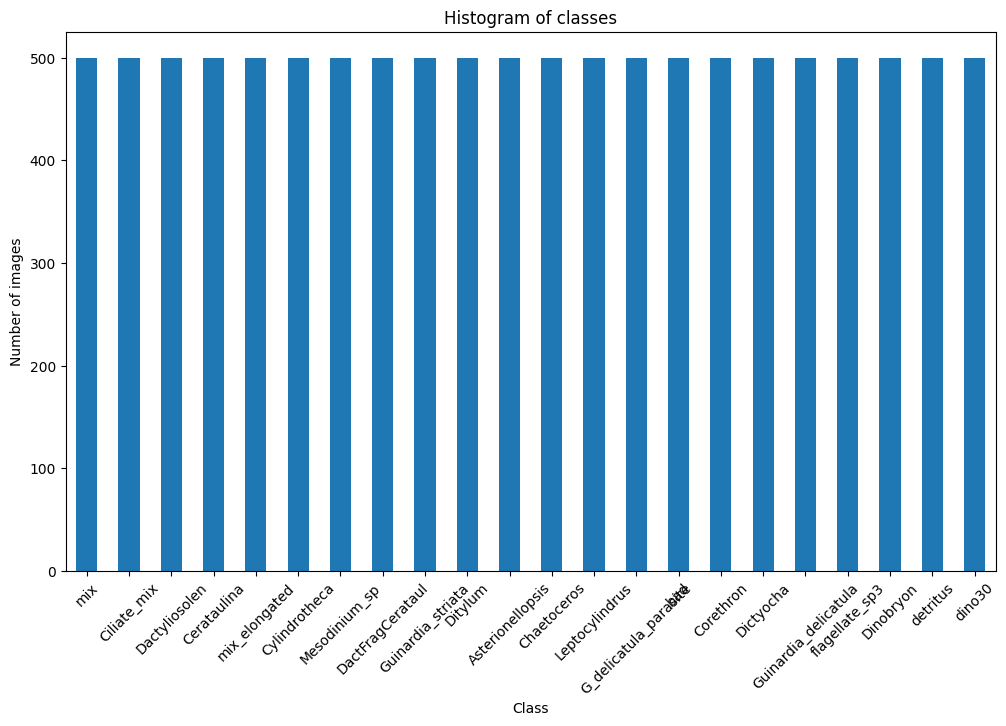

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
counts.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Histogram of classes")
plt.xticks(rotation=45)
plt.show()


# Model 1. RESNET 50

# 1. Split into train & test

In [8]:
# Keep only rows where image is not

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


df_clean = df[df["Image_Matrix"].notnull()].reset_index(drop=True)

X = df_clean["Image_Matrix"].values
y = df_clean["Image_Class"].values


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 2. Preprocess the images

ResNet50 expects 3-channel images of size 224×224. Plankton data is grayscale, so stack it into 3 channels.

In [10]:
def preprocess_images(images, img_size=224):
    processed = []
    for img in images:
        if img is None:  # skip bad images
            continue

        img = np.array(img)

        # If grayscale (H, W), add channel
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)

        # Resize
        img = tf.image.resize(img, (img_size, img_size))

        # Convert grayscale → RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        processed.append(img.numpy())
    return np.array(processed)



In [11]:
X_train_prep = preprocess_input(preprocess_images(X_train))
X_test_prep  = preprocess_input(preprocess_images(X_test))


# 3. Encode labels

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc  = to_categorical(le.transform(y_test))
num_classes = y_train_enc.shape[1]


# 4. Use Resnet50:

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
#data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_gen = datagen.flow(X_train_prep, y_train_enc, batch_size=64)


In [15]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7
)

In [16]:
history = model.fit(
    X_train_prep, y_train_enc,
    validation_data=(X_test_prep, y_test_enc),
    epochs=15,
    batch_size=64
)


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 202ms/step - accuracy: 0.5002 - loss: 1.6702 - val_accuracy: 0.8594 - val_loss: 0.4393
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8537 - loss: 0.4893 - val_accuracy: 0.8953 - val_loss: 0.3411
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8901 - loss: 0.3636 - val_accuracy: 0.9031 - val_loss: 0.3072
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9099 - loss: 0.2951 - val_accuracy: 0.9043 - val_loss: 0.2819
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9089 - loss: 0.2719 - val_accuracy: 0.9067 - val_loss: 0.2805
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9245 - loss: 0.2342 - val_accuracy: 0.9133 - val_loss: 0.2689
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9308 - loss: 0.2174 - val_accuracy: 0.9073 - val_loss: 0.2587
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9366 - loss: 0.2017 - val_ac

In [17]:
loss, acc = model.evaluate(X_test_prep, y_test_enc)
print(f"Test accuracy: {acc:.2f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9162 - loss: 0.2557
Test accuracy: 0.92


# 5. Fine-tuning

In [48]:
# FT 🔓 Unfreeze the last ~30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


In [50]:
history_finetune = model.fit(
    X_train_prep, y_train_enc,
    validation_data=(X_test_prep, y_test_enc),
    epochs=20,              # longer this time
    batch_size=64,          # maybe smaller for better generalization
    callbacks=[early_stop, lr_scheduler]  # if you add them
)


Epoch 1/20


KeyboardInterrupt: 

In [24]:
loss, acc = model.evaluate(X_test_prep, y_test_enc)
print(f"Test accuracy: {acc:.2f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9391 - loss: 0.2255
Test accuracy: 0.94


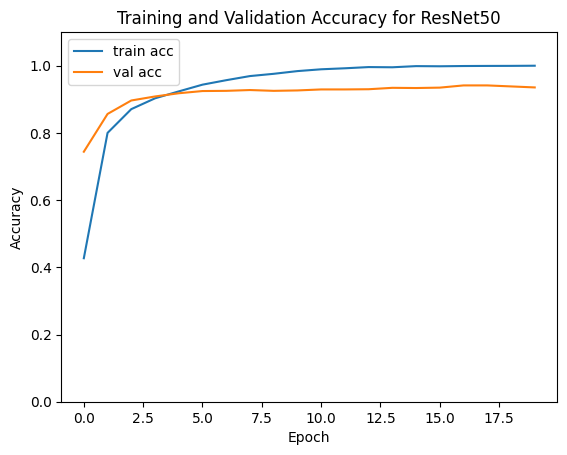

In [28]:
# plot epoch curve

import matplotlib.pyplot as plt

plt.plot(history_finetune.history['accuracy'], label='train acc')
plt.plot(history_finetune.history['val_accuracy'], label='val acc')
# make y axis start at 0
plt.ylim(0, 1.1)
# add axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# add title
plt.title('Training and Validation Accuracy for ResNet50')
# add legend
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(X_test_prep)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)


53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Overall accuracy:", accuracy_score(y_true, y_pred))

# Detailed metrics per class
report = classification_report(
    y_true, y_pred, target_names=le.classes_, digits=3
)
print(report)


Overall accuracy: 0.9258373205741627
                       precision    recall  f1-score   support

     Asterionellopsis      0.947     0.957     0.952        94
          Cerataulina      0.818     0.890     0.853        91
          Chaetoceros      0.920     0.931     0.926        87
            Corethron      0.980     0.980     0.980       100
        Cylindrotheca      0.990     0.970     0.980       100
     DactFragCerataul      0.904     0.850     0.876       100
        Dactyliosolen      0.979     0.950     0.964       100
            Dictyocha      0.971     0.990     0.980       100
            Dinobryon      0.990     0.990     0.990       100
              Ditylum      0.960     0.950     0.955       100
G_delicatula_parasite      0.752     0.790     0.771       100
 Guinardia_delicatula      0.777     0.730     0.753       100
    Guinardia_striata      0.960     0.950     0.955       100
       Leptocylindrus      0.941     0.960     0.950       100
        Mesodiniu

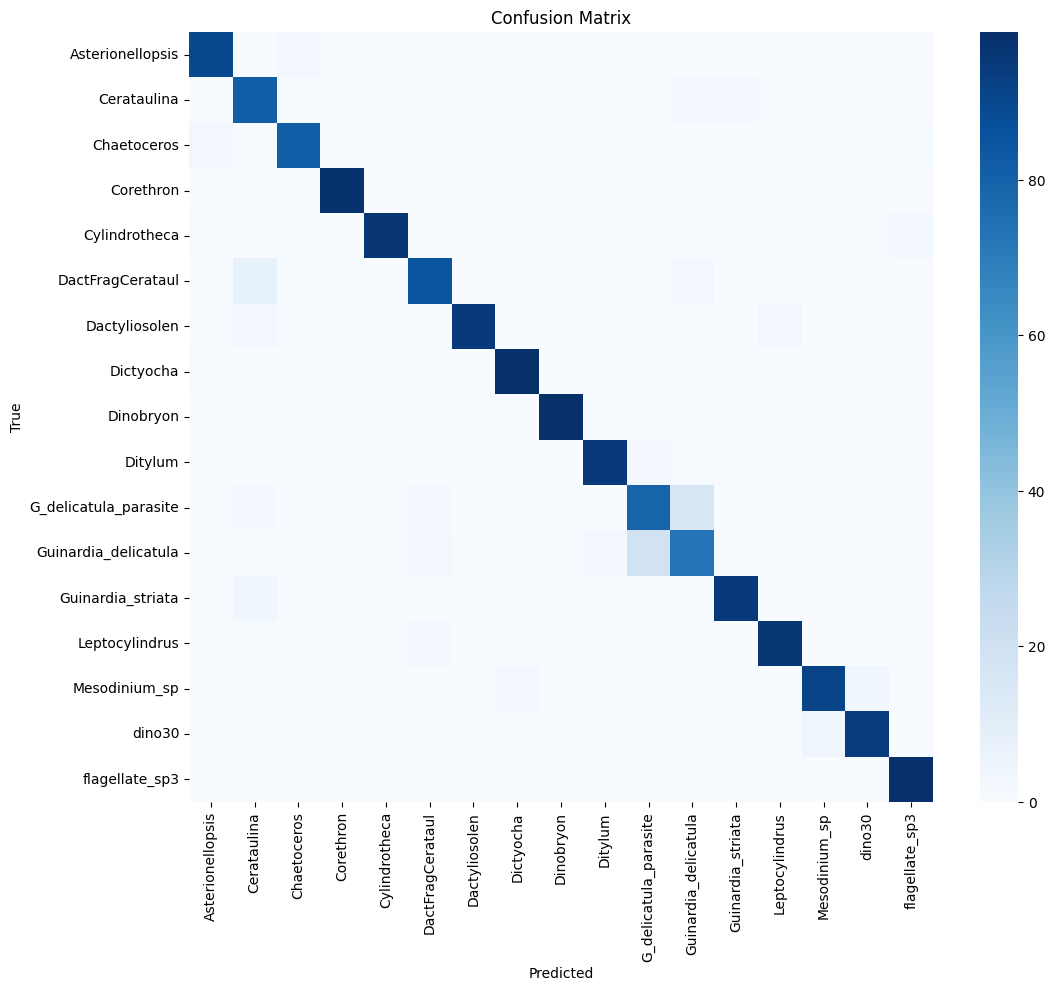

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


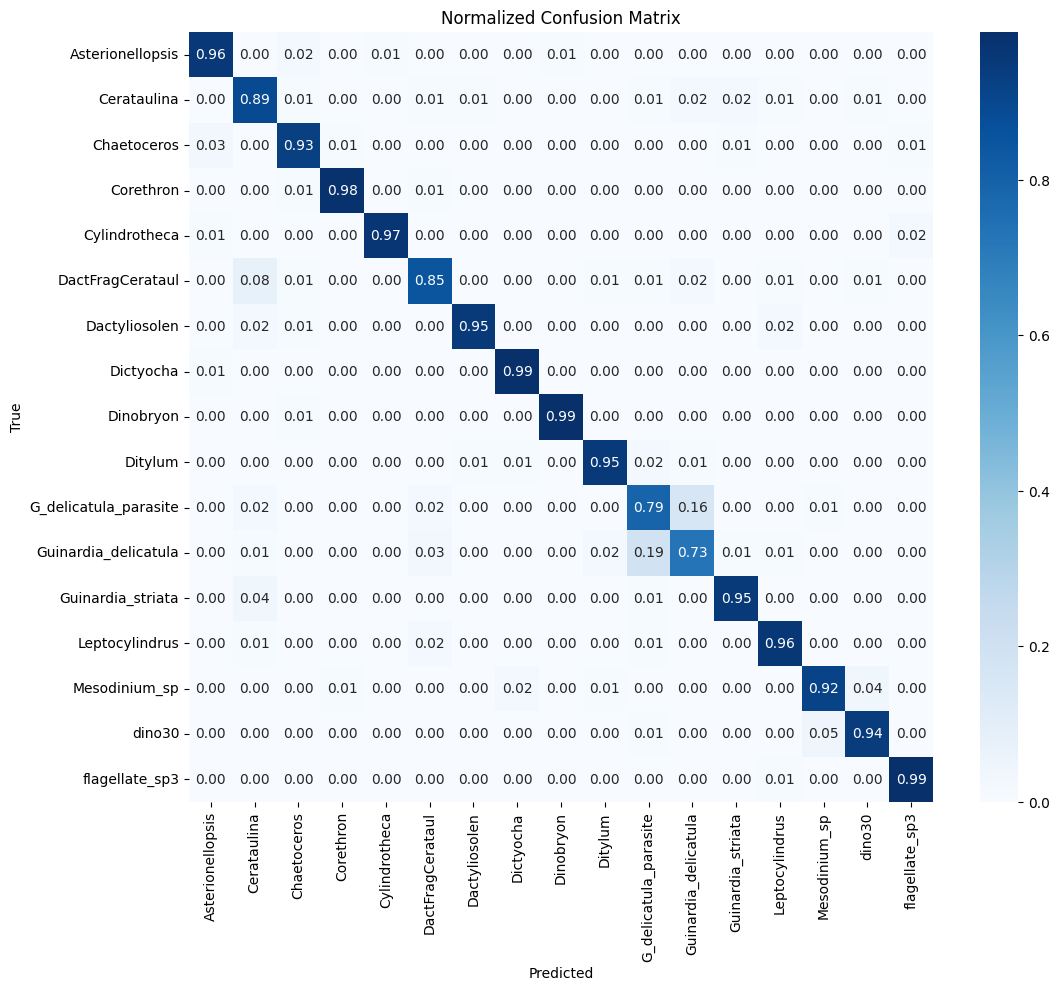

In [ ]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


In [ ]:
model.save("resnet50Attempt2.keras")

# RESNET50 Testing with real Photo


In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

#download jpeg to put into model
img_path = "/content/drive/MyDrive/Plankton/Other_data/lepto2.jpg"

In [19]:
# === Step 2: Load and preprocess ===
img = image.load_img(img_path, target_size=(64, 64))  # ResNet50 expects 224x224
x = image.img_to_array(img)


In [20]:


# ResNet50 expects 3 channels, so repeat grayscale channel into RGB
x = np.stack((x,)*3, axis=-1)

x = np.expand_dims(x, axis=0)  # add batch dimension
x = tf.keras.applications.resnet50.preprocess_input(x)

# Replace with your actual class list in the same order as training
class_names = [
    "Asterionellopsis",
    "Cerataulina",
    "Chaetoceros",
    "Corethron",
    "Cylindrotheca",
    "DactFragCerataul",
    "Dactyliosolen",
    "Dictyocha",
    "Dinobryon",
    "Ditylum",
    "G_delicatula_parasite",
    "Guinardia_delicatula",
    "Guinardia_striata",
    "Leptocylindrus",
    "Mesodinium_sp",
    "dino30",
    "flagellate_sp3"
]

predicted_class = class_names[np.argmax(preds)]
confidence = np.max(preds)

# === Step 4: Show result ===
plt.imshow(image.load_img(img_path))  # original image
plt.axis("off")
plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
plt.show()

ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

# MODEL2 RESNETX

In [ ]:
!pip install image-classifiers


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from classification_models.tfkeras import Classifiers


In [ ]:
df_clean = df[df["Image_Matrix"].notnull()].reset_index(drop=True)

X = df_clean["Image_Matrix"].values
y = df_clean["Image_Class"].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc  = to_categorical(le.transform(y_test))

num_classes = y_train_enc.shape[1]


In [ ]:
# Load ResNeXt50 + preprocessing function
ResNeXt50, preprocess_input = Classifiers.get('resnext50')
IMG_SIZE = 224

def preprocess_images(X):
    processed = []
    for img in X:
        if img is None:
            continue
        img = np.array(img)

        # ensure 2D grayscale
        if img.ndim == 3 and img.shape[-1] > 1:
            img = tf.image.rgb_to_grayscale(img).numpy().squeeze()

        # resize (keeps grayscale)
        img_resized = tf.image.resize(
            tf.expand_dims(img, axis=-1), (IMG_SIZE, IMG_SIZE)
        )

        # convert grayscale → 3-channel fake RGB
        img_rgb = tf.image.grayscale_to_rgb(img_resized)

        processed.append(img_rgb.numpy())

    processed = np.array(processed, dtype=float)
    return tf.keras.applications.resnet50.preprocess_input(processed)



In [ ]:
X_train_prep = preprocess_images(X_train)
X_test_prep  = preprocess_images(X_test)

print("Train shape:", X_train_prep.shape)
print("Test shape:", X_test_prep.shape)


Train shape: (6688, 224, 224, 3)
Test shape: (1672, 224, 224, 3)


In [ ]:

# Build model
base_model = ResNeXt50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=preds)

# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
history = model.fit(
    X_train_prep, y_train_enc,
    validation_data=(X_test_prep, y_test_enc),
    epochs=20,
    batch_size=64
)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 402ms/step - accuracy: 0.4475 - loss: 1.8434 - val_accuracy: 0.8361 - val_loss: 0.5833
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8114 - loss: 0.6325 - val_accuracy: 0.8684 - val_loss: 0.4379
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8384 - loss: 0.5104 - val_accuracy: 0.8744 - val_loss: 0.3975
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8725 - loss: 0.4095 - val_accuracy: 0.8882 - val_loss: 0.3690
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8836 - loss: 0.3753 - val_accuracy: 0.8840 - val_loss: 0.3546
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8913 - loss: 0.3414 - val_accuracy: 0.8941 - val_loss: 0.3318
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9003 - loss: 0.3182 - val_accuracy: 0.8989 - val_loss: 0.3184
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9072 - loss: 0.3028 - val_ac

In [ ]:
loss, acc = model.evaluate(X_test_prep, y_test_enc)
print(f"Test accuracy: {acc:.2f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8949 - loss: 0.3125
Test accuracy: 0.90


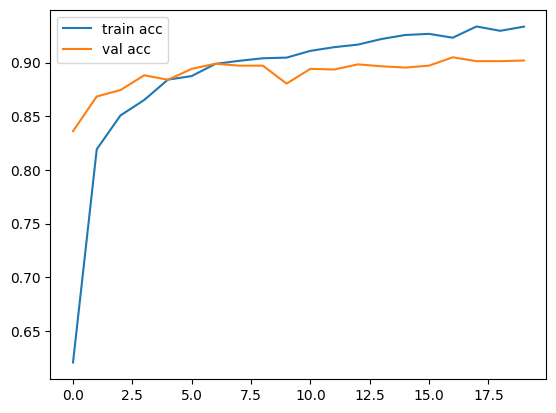

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [ ]:
model.save("resneXtAttempt2.keras")